In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm


import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import *

from tensorflow.keras import layers
from tensorflow.keras import activations
%matplotlib inline 


import random

In [2]:
class RBF_Net(object):
    def __init__(self):
        return 
        
        
    def fit(self, X_train, Y_train, C):
        self.X = X_train
        self.Y = Y_train.T
        self.C = C
        self.N = len(self.C)
        self.S = len(self.X)
        self.d_constr()
        self.F_constr()
        self.train()
        
        self.y_dim = len(Y_train[0])
        self.x_dim = len(X_train[0])
            
    def a_func(self,x,v,d):
        return  np.exp(-((np.linalg.norm(x - v))/d)**2)

    def d_constr(self):
        d = np.zeros(self.N)
        l = np.zeros(self.N)
        for i in tqdm(range(self.N),"Distant progress"):
            for j in range(self.N):
                l[j] = np.linalg.norm(self.C[i] - self.C[j])
            d[i] = np.std(l)
        self.d = d

    def F_constr(self):
        F = np.zeros((self.N, self.S))
        for i in tqdm(range(self.N),"F progress"):
            for j in range(self.S):
                F[i][j] = self.a_func(self.X[j], self.C[i],self.d[i])
        self.F = F
        print(np.shape(F))
    
    def train(self):
        a = np.zeros(self.S)
        
        for i in range(self.S):
            a[i] = 1
            
        a = np.reshape(a, (-1, 1))
        FA = self.F.T
        FA = np.hstack((FA, a))
        FA = FA.T
        
        FAFAT =tf.linalg.matmul(FA, FA, transpose_b=True)

        self.mu = np.linalg.cond(tf.make_ndarray(tf.make_tensor_proto(FAFAT)))
        FAFAT = tf.linalg.pinv(FAFAT, rcond = 10**(-100), validate_args = True)
        
        
        Wb =  tf.linalg.matmul(self.Y, FA, transpose_b=True)
        Wb =  tf.linalg.matmul(Wb, FAFAT)

        YY = tf.linalg.matmul(Wb, FA)

        Wb = tf.make_tensor_proto(Wb)
        Wb = tf.make_ndarray(Wb)
        self.W = np.copy(Wb[:,:self.N])
        self.b = np.copy(Wb[:,self.N:]) 
    
    def predict_mode(self, V):
        F = np.zeros((1,self.N))
        for i in range(self.N):
            F[0][i] = self.a_func(V, self.C[i], self.d[i])
        return np.reshape(np.dot(self.W, F.T) + self.b, (1,-1))
    
    
    def predict_v(self, V):
        return 
        
    
    def predict(self, x):
    
        y_pred = np.zeros((0,self.y_dim))
        for i in tqdm(range(len(x))):
            y_pred = np.vstack((y_pred, rbf.predict_mode(x[i])))
        return y_pred
                     
    pass

In [3]:
def weighting(X, func_type):

    if func_type == 'sin':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)
        return X*weight

    if func_type == 'sin^2':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**2
        return X*weight

    if func_type == 'sin^4':
        k = np.pi / 180
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.sin(angles*k)**4
        return X*weight

    if func_type == '1-log':
        return 1 - (X[:,0:1] ** 2 + X ** 2) / 10

    if func_type == 'log':
        return np.log(X)

    if func_type == 'm_func':
        angles = np.array(range(0,181),dtype = 'float64')
        weight = np.copy(angles)
        for i in range(len(angles)):
            if i == 0:
                weight[i] = 0
            if (i > 0) and (i < 90):
                weight[i] = (np.exp(-2*(np.log(i/54.0))**2))/i
            
            if (i > 90):
                weight[i] = weight[181-i]

        return X * weight

def cutter(X, start, end):
    return X[:,start:end+1]

In [4]:
def predict_plot(y_test, y_pred, params):
    N = len(params)
    
    plt.figure(figsize=(20,20))
    
    for i in range (N):
        for j in range(N):
            plt.subplot(N, N, i*N+j+1)

            plt.title("Предсказание с помощью сетей")
            plt.xlabel(params[i])
            plt.ylabel(params[j])

            plt.plot(y_test[:,i], y_test[:,j] ,'*', label = "Тест")
            plt.plot(y_pred[:,i], y_pred[:,j], '.', label = "Предсказание")
            plt.legend()


def error_plot(y_test, y_pred, params):
    
    N = len(params)
    
    error = []
    for j in range(len(y_pred[0])):
        buf_err = []    
        for i in range(len(y_pred)):
            buf_err.append((y_test[i,j]-y_pred[i,j]))   
        error.append(buf_err)


    plt.figure(figsize=(20,20))
    
    for i in range (N):
        
        plt.subplot(N, 2, i*2+1)
        plt.title("Ошибка предсказания %s" %(params[i]))
        plt.ylabel("Ошибка предсказания %s" %(params[i]))
        plt.xlabel("Номер индикатрисы")
        plt.plot(error[i],'*')
        
    
        plt.subplot(N, 2, i*2+2)
        plt.title("Распределение ошибки %s" %(params[i]))
        plt.xlabel("Ошибка предсказания %s" %(params[i]))
        plt.hist(error[i], 100)
        plt.text(0,0,'mu = %f \n sigma = %f' %(np.mean(error[i]),np.std(error[i])),bbox=dict(facecolor='white'))

    return error

In [5]:
col_list = ['r', 'x' ,'n', 'tetha']
for i in range(181):
    col_list.append(str(i))

df = pd.read_csv('Plt_200k_h2.csv', delimiter = ';', names = col_list)
#print(df[df['r'] == 0].index)
df = df.drop(df[df['r'] == 0].index)
df = df.reset_index(drop=True)

In [6]:
xx = np.log(np.array(df)[:,4:])
yy = np.array(df)[:, :4]
#xx = weighting(xx, 'm_func')
#xx = cutter(xx, 0 , 90)

In [7]:
x_train,x_test,y_train,y_test= train_test_split(xx, yy, test_size=0.01, shuffle=True)

In [8]:
#y_train = np.array(df)[:, :2]
#x_train = (np.array(df)[:,2:])

#y_test = np.array(df_test)[:, :2]
#x_test = (np.array(df_test)[:,2:])

#x_train = cutter(x_train, 5 , 70)
#x_test = cutter(x_test, 5 , 70)

In [9]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2000, random_state=0, max_iter = 40, verbose = True)

print(kmeans.fit(xx))

Initialization complete
Iteration 0, inertia 6035034.687649105
Iteration 1, inertia 4731771.681403577
Iteration 2, inertia 4620456.9954217225
Iteration 3, inertia 4573105.566931651
Iteration 4, inertia 4544045.924677625
Iteration 5, inertia 4523981.5242251465
Iteration 6, inertia 4508816.127874601
Iteration 7, inertia 4497111.98601801
Iteration 8, inertia 4488094.916053568
Iteration 9, inertia 4480709.343598863
Iteration 10, inertia 4474448.021075328
Iteration 11, inertia 4469142.529208125
Iteration 12, inertia 4464546.49504337
Iteration 13, inertia 4460805.750383092
Iteration 14, inertia 4458076.621245006
Iteration 15, inertia 4455847.938566517
Iteration 16, inertia 4454018.267472094
Iteration 17, inertia 4452250.434187931
Iteration 18, inertia 4450862.971868429
Iteration 19, inertia 4449570.124309697
Iteration 20, inertia 4448171.694845237
Iteration 21, inertia 4446870.39700311
Iteration 22, inertia 4445769.482305592
Iteration 23, inertia 4444851.570850439
Iteration 24, inertia 44441

Iteration 3, inertia 4577782.18699215
Iteration 4, inertia 4547796.253450408
Iteration 5, inertia 4526776.227811728
Iteration 6, inertia 4510758.982881524
Iteration 7, inertia 4498571.440532554
Iteration 8, inertia 4489494.217320265
Iteration 9, inertia 4481826.067355209
Iteration 10, inertia 4475403.492572101
Iteration 11, inertia 4469877.075426825
Iteration 12, inertia 4465275.101449652
Iteration 13, inertia 4461522.631596024
Iteration 14, inertia 4458618.358184355
Iteration 15, inertia 4456016.077178588
Iteration 16, inertia 4453802.928314408
Iteration 17, inertia 4451968.335932211
Iteration 18, inertia 4450410.767234106
Iteration 19, inertia 4449071.979594559
Iteration 20, inertia 4447771.7690266445
Iteration 21, inertia 4446639.250772816
Iteration 22, inertia 4445581.46690549
Iteration 23, inertia 4444526.37632891
Iteration 24, inertia 4443509.112181662
Iteration 25, inertia 4442561.926789031
Iteration 26, inertia 4441580.324578963
Iteration 27, inertia 4440530.110511129
Iteration

In [10]:
C = kmeans.cluster_centers_
C

array([[ 5.69865321,  5.68429868,  5.64111238, ..., -6.01318515,
        -6.13328416, -6.22749267],
       [ 9.45140148,  9.40873729,  9.27949771, ..., -4.74594462,
        -5.57605658, -6.76329402],
       [ 6.48480348,  6.4754639 ,  6.44738013, ..., -2.35856934,
        -2.35677306, -2.35617204],
       ...,
       [ 7.66318468,  7.64169956,  7.57707428, ..., -4.94629793,
        -4.97979868, -5.00081914],
       [10.60188937, 10.57024052, 10.47444338, ..., -2.25510173,
        -2.24776884, -2.24521885],
       [ 9.6914839 ,  9.66191471,  9.57420801, ..., -4.89392807,
        -4.89817144, -4.8997026 ]])

In [11]:
rbf = RBF_Net()
rbf.fit(x_train, y_train, C)
y_pred = rbf.predict(x_test)

F progress: 100%|████████████████████████| 2000/2000 [1:10:10<00:00,  2.11s/it]


(2000, 197819)


100%|██████████████████████████████████████| 1999/1999 [00:43<00:00, 46.40it/s]


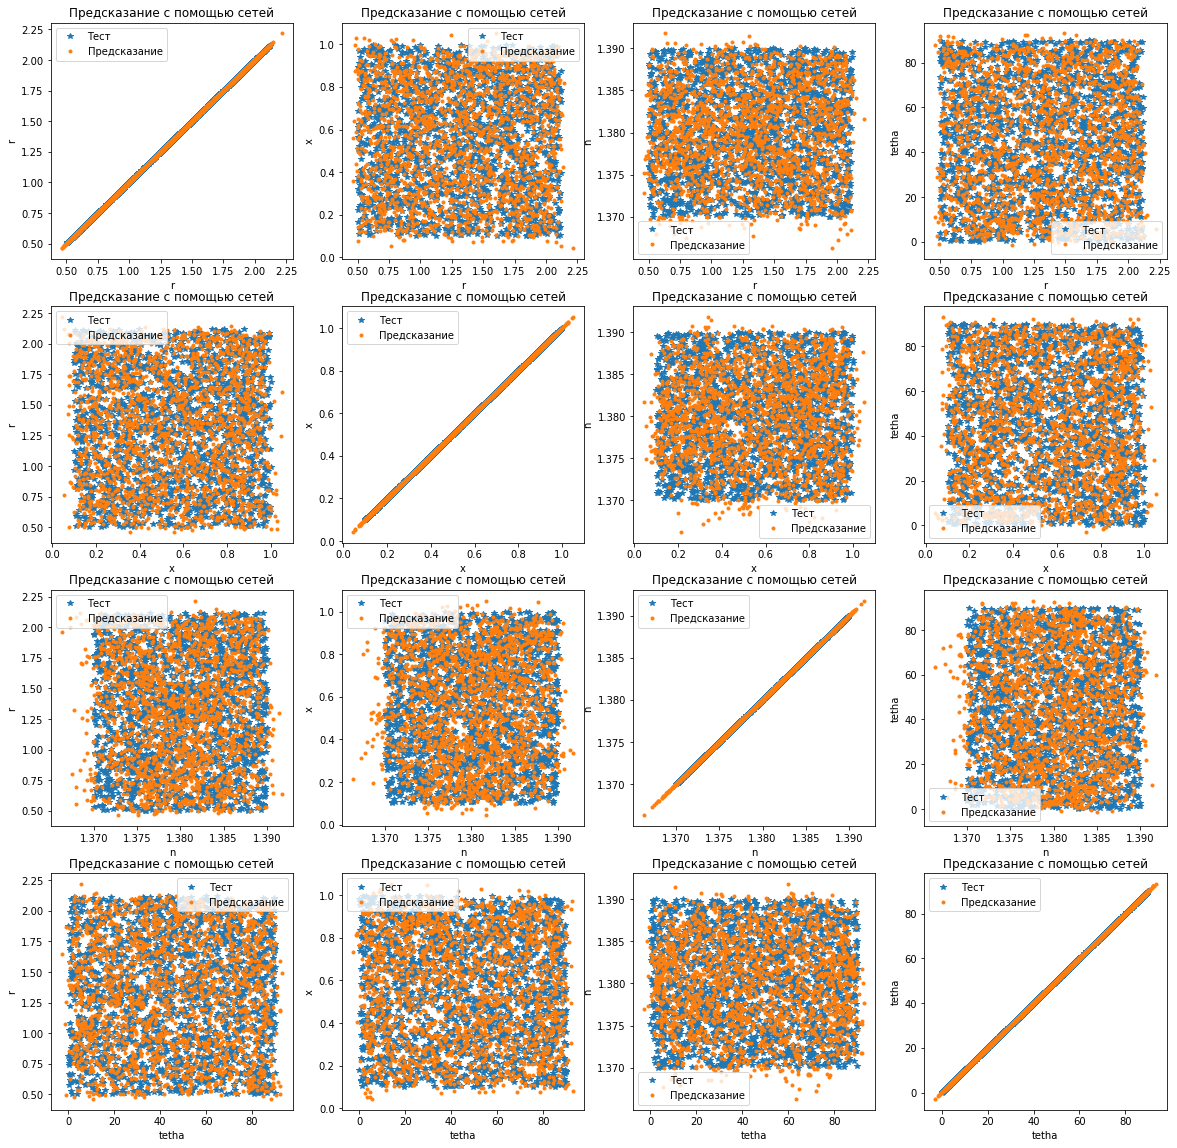

In [12]:
predict_plot(y_test, y_pred, ['r', 'x' ,'n', 'tetha'])

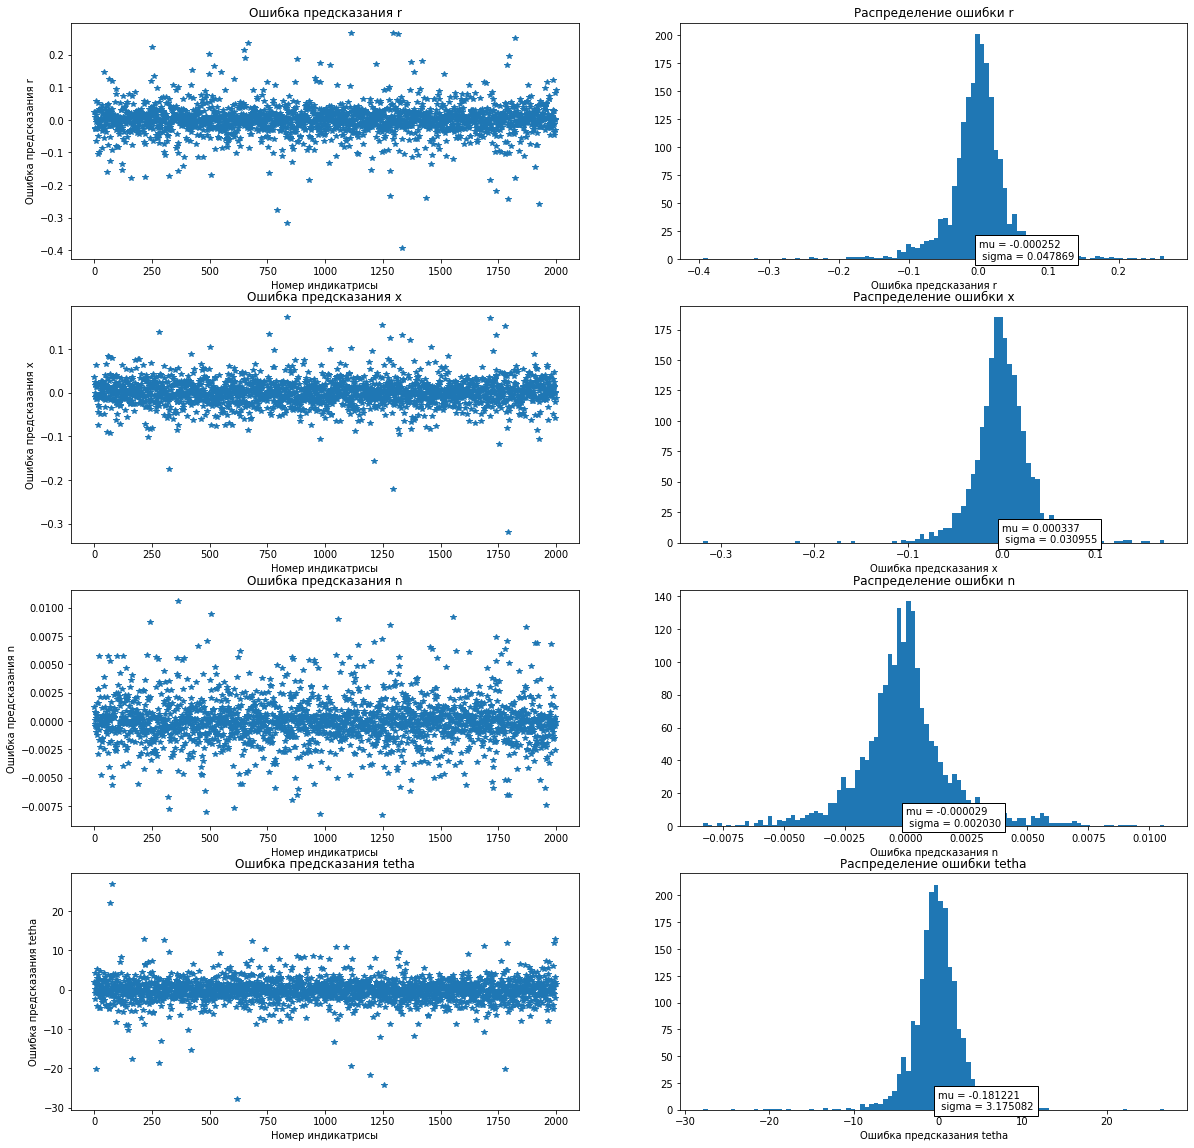

In [13]:
errors = error_plot(y_test, y_pred, ['r', 'x' ,'n', 'tetha'])

In [14]:
np.savetxt(r'C:\Users\Eugen\RBF\C.txt', rbf.C)
np.savetxt(r'C:\Users\Eugen\RBF\X.txt', rbf.X)
np.savetxt(r'C:\Users\Eugen\RBF\Y.txt', rbf.Y)
np.savetxt(r'C:\Users\Eugen\RBF\d.txt', rbf.d)
np.savetxt(r'C:\Users\Eugen\RBF\W.txt', rbf.W)
np.savetxt(r'C:\Users\Eugen\RBF\b.txt', rbf.b)